# Notebook used to train a 2D StarDist model with phase contrast images of <i>S. suis
________________________________________________________________________________________________________________

## Load dependencies

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread, imsave
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

from augmend import Augmend           
from augmend import Elastic, FlipRot90, AdditiveNoise, Rotate, IntensityScaleShift

import pandas as pd
import csv
import shutil 
import os
import time

np.random.seed(42)
lbl_cmap = random_label_cmap()

## Check for GPU access


In [2]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Load Data

Adjust path to training images accordingly

In [3]:
X = sorted(glob('TrainingData/images_augmented/*.tif'))
Y = sorted(glob('TrainingData/masks_augmented/*.tif'))

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes

In [5]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 80/80 [00:03<00:00, 25.28it/s]


Split into train and validation datasets.

In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.2 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  80
- training:        64
- validation:      16


Visualize examplary traning data set (raw image and corresponding label image)

In [7]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

In [8]:
i = min(1, len(X)-1)
img, lbl = X_trn[i], Y_trn[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;


## Configuration

A StarDist2D model is specified via a Config2D object.


In [9]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter_base : int
        Number of convo

In [10]:
# 32 is a good default choice
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

# Optimize settings based on your data
conf = Config2D (
    unet_n_depth = 4,
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_epochs = 400,
    train_batch_size = 16,
    unet_batch_norm = False
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=4, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'unet_n_depth': 4,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 16,
 'train_n_val_patches': None,
 'train_tensorboard': True

In [11]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    #limit_gpu_memory(0.8)
    # alternatively, try this:
    limit_gpu_memory(None, allow_growth=True)

In [12]:
model = StarDist2D(conf, name='stardist_demo', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [13]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [944. 944.]
network field of view :  [128 128]



## Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.
We here use an augmenter that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting augmenter = None).


In [14]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    #img = img*np.random.uniform(0.6,1.2) + np.random.uniform(-0.1,0.1)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    #x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

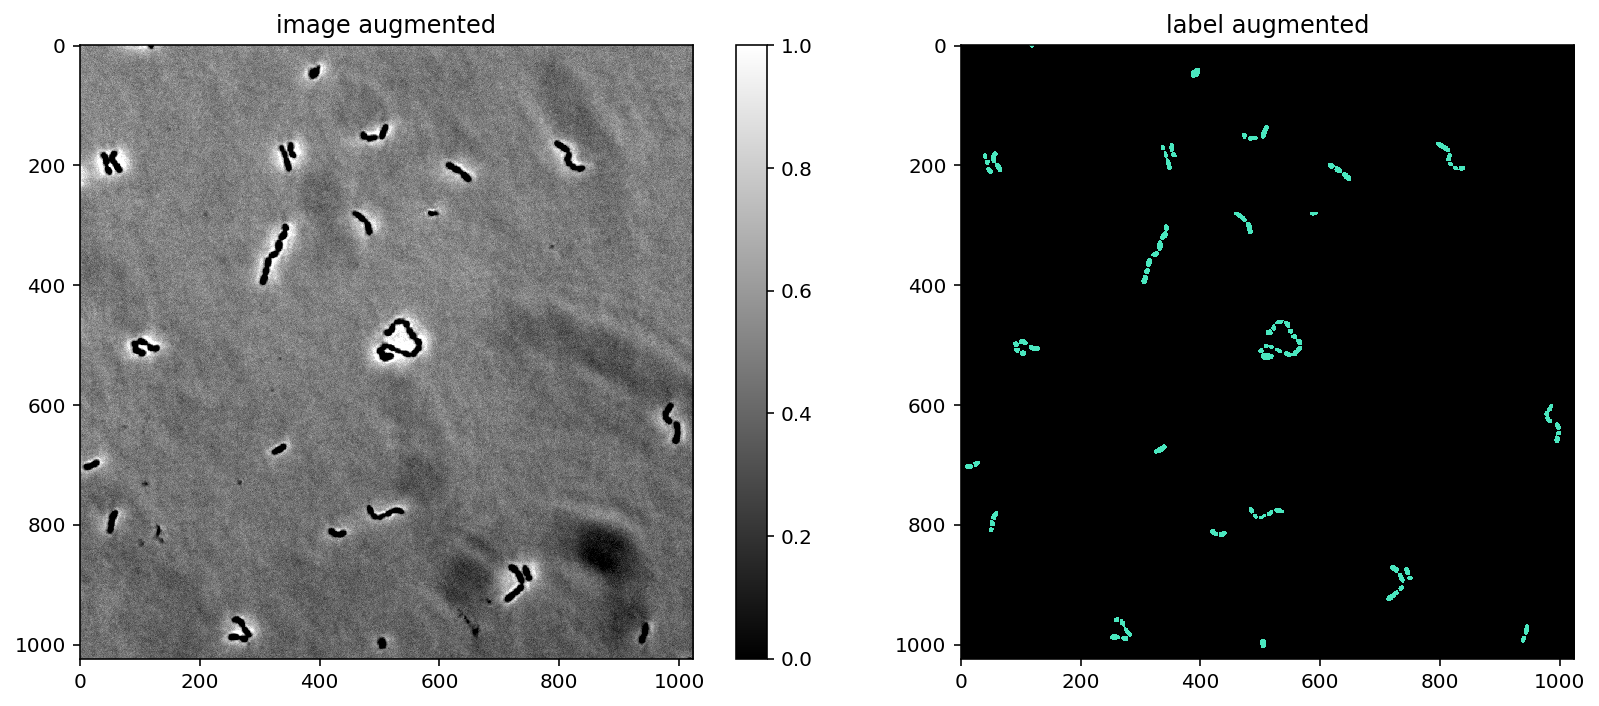

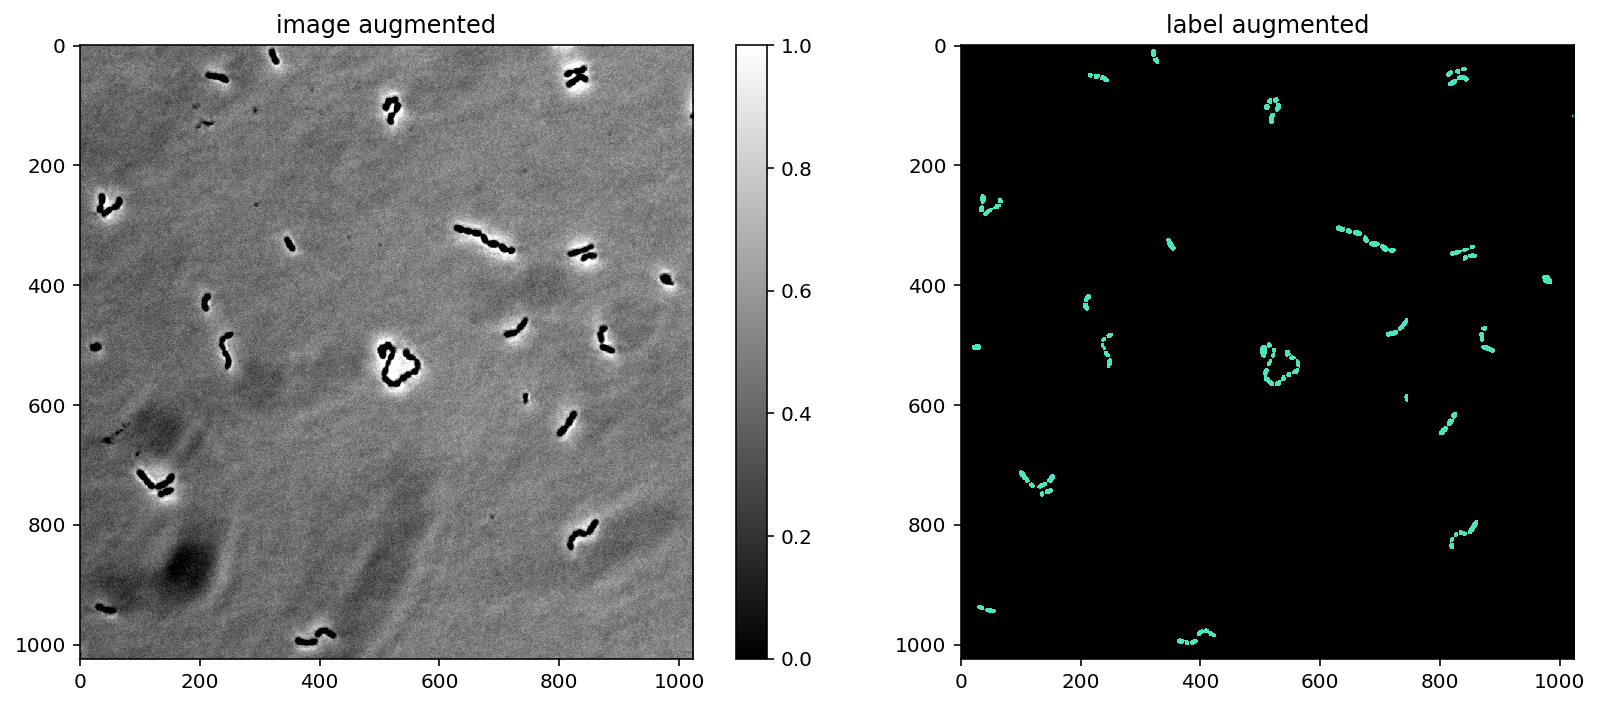

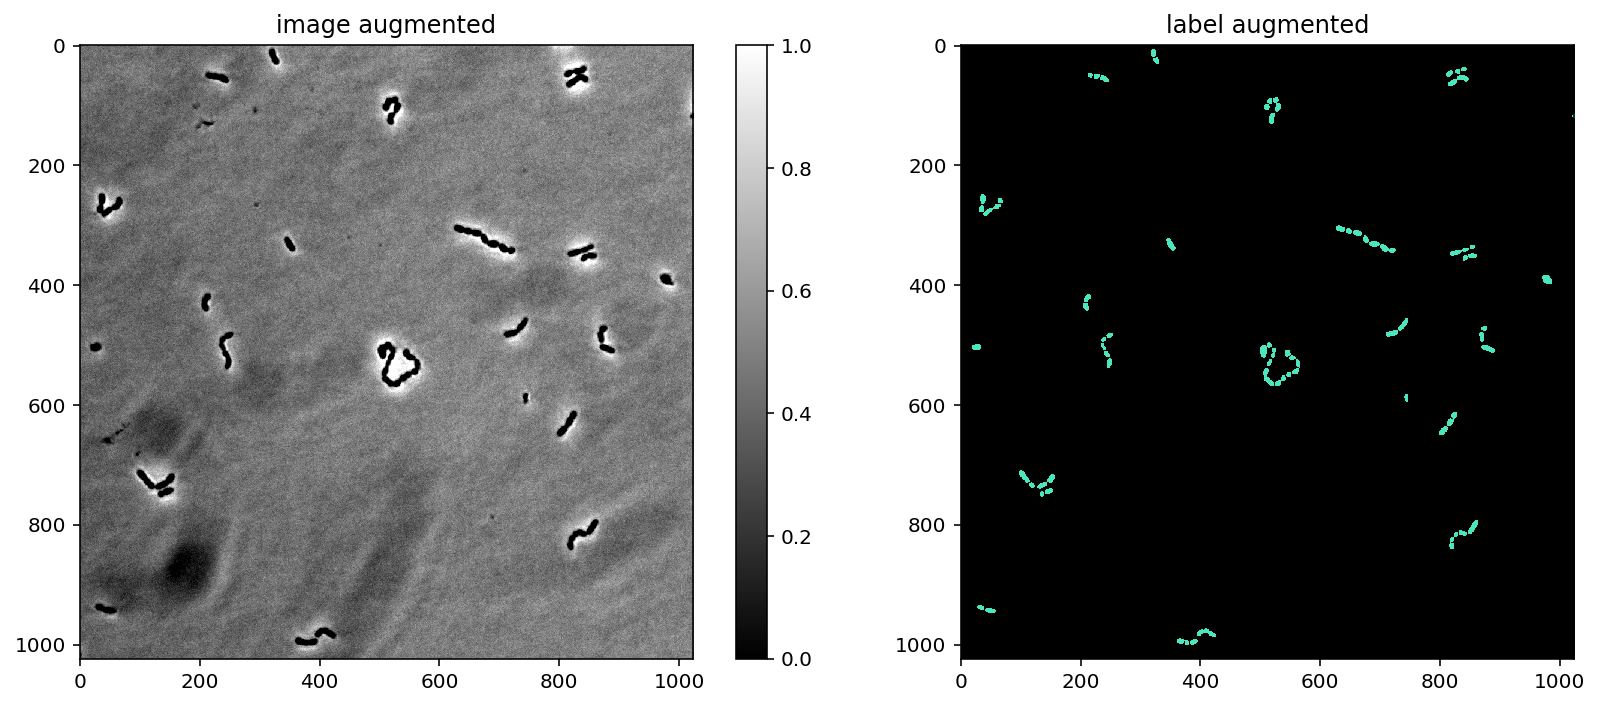

In [15]:
# plot some augmented examples
img, lbl = X[10],Y[10]
plot_img_label(img, lbl)
for _ in range(5):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")


## Training¶

We recommend to monitor the progress during training with TensorBoard. You can start it in the shell from the current working directory like this:

$ tensorboard --logdir=.

Then connect to http://localhost:6006/ with your browser.


In [16]:
quick_demo = True

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D(None, name = 'models/stardist_5')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;



NOTE: This is only for a quick demonstration!
      Please set the variable 'quick_demo = False' for proper (long) training.


Epoch 1/2
10/10 [==============================] - 4s 391ms/step - loss: 1.6581 - prob_loss: 0.5508 - dist_loss: 5.5363 - prob_kld: 0.5399 - dist_relevant_mae: 5.5362 - dist_relevant_mse: 43.6085 - val_loss: 1.3171 - val_prob_loss: 0.1202 - val_dist_loss: 5.9846 - val_prob_kld: 0.0709 - val_dist_relevant_mae: 5.9843 - val_dist_relevant_mse: 58.7019
Epoch 2/2
10/10 [==============================] - 3s 260ms/step - loss: 1.1015 - prob_loss: 0.0961 - dist_loss: 5.0273 - prob_kld: 0.0771 - dist_relevant_mae: 5.0272 - dist_relevant_mse: 40.1493 - val_loss: 1.0031 - val_prob_loss: 0.0894 - val_dist_loss: 4.5682 - val_prob_kld: 0.0668 - val_dist_relevant_mae: 4.5679 - val_dist_relevant_mse: 34.9110


====> Stopping training and loading previously trained demo model from disk.



Loading network weights from 'weights_best.h5'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.409794, nms_thresh=0.3.



## Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.


In [17]:
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:05<00:01,  2.98it/s, 0.409 -> 0.000]


Using optimized values: prob_thresh=0.409794, nms_thresh=0.3.
Saving to 'thresholds.json'.


## Evaluation

In [18]:
# Load test data
Z = sorted(glob('TestData/Images/*.tif'))
Z = list(map(imread,Z))
n_channel = 1 if Z[0].ndim == 2 else Z[0].shape[-1]
print('')
print('Number of test images found in the folder: '+str(len(Z)))

# Load corresponding GT images
GT = sorted(glob('TestData/GT/*.tif'))
GT = list(map(imread,GT))
print('Number of GT images found in the folder: '+str(len(GT)))
print('')

# Normalize test images.
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
n_channel = 1
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

print('Normalizing test images')
Z = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(Z)]

 40%|████      | 4/10 [00:00<00:00, 39.78it/s]


Number of test images found in the folder: 10
Number of GT images found in the folder: 10

Normalizing test images


100%|██████████| 10/10 [00:00<00:00, 45.13it/s]


In [19]:
Z_pred = [model.predict_instances(x,  n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(Z)]

100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


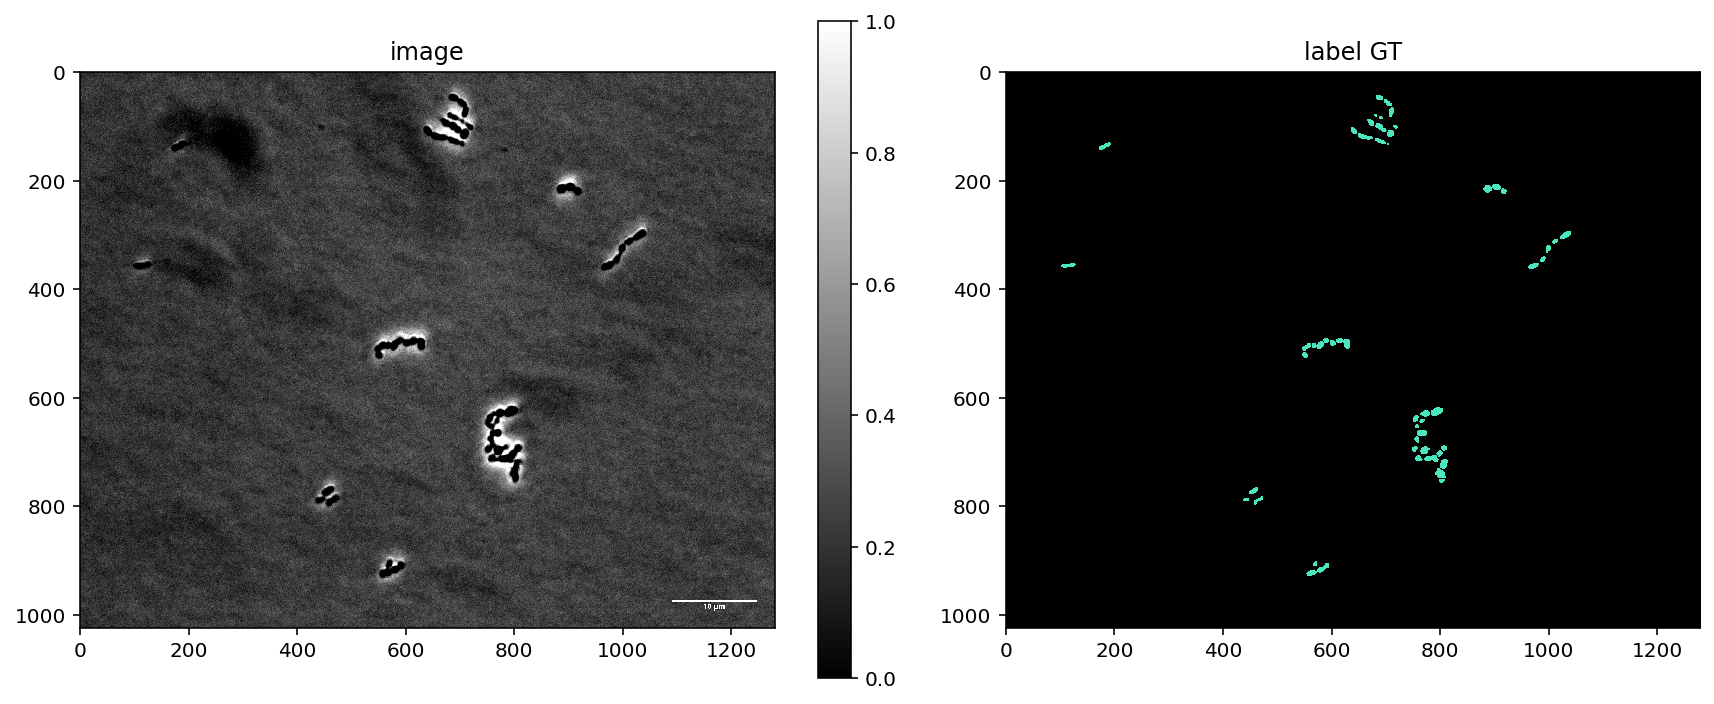

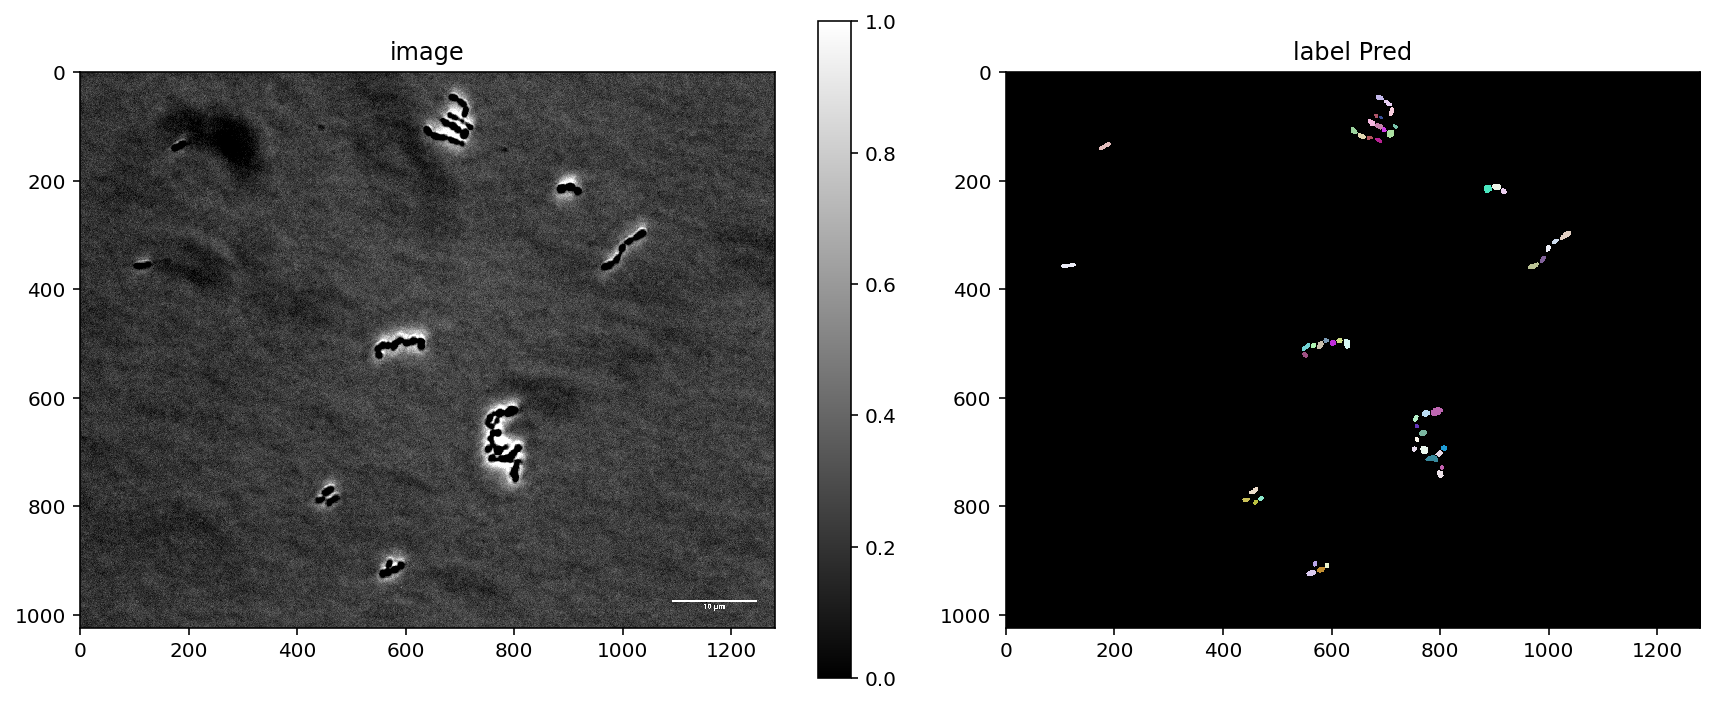

In [20]:
plot_img_label(Z[0],GT[0], lbl_title="label GT")
plot_img_label(Z[0],Z_pred[0], lbl_title="label Pred")